# Exploratory Research of Object Recognition Based on Deep Learning and Single image Super Resolution

## License and Source Code References
* The code in the document by Erik Linder-Norén and Magnus Erik Hvass Pedersen is licensed under the MIT License https://opensource.org/licenses/MIT
* Availability: https://github.com/Hvass-Labs/TensorFlow-Tutorials and https://github.com/eriklindernoren/Keras-GAN

## Prerequisite 

* Python version should be 3.0+. Check your python version. Open an terminal and type in python --version. If you only have 2.7 installed. Install python 3.0+. From https://www.python.org/downloads/mac-osx/. Here is a useful guide: http://docs.python-guide.org/en/latest/starting/install3/osx/
* Install the latest Anaconda. Here is a useful guide: https://conda.io/docs/user-guide/install/index.html
* To connect to google cloud platform you need to Install mysql. Open an terminal and use pip3 install mysql
* Install tensorflow. Open terminal and pip3 install tensorflow
* Install prettytensor. Open terminal and pip3 install prettytensor
* Install keras. Open terminal and pip3 install keras
* Download TensorFlow-Tutorials-master from from https://github.com/Hvass-Labs/TensorFlow-Tutorials. After downloading, uncompress all the files.
* Download helper.py from https://github.com/lishahan/CSYE7245_2018Spring/tree/master/FinalProject and put it in TensorFlow-Tutorials-master folder.
* Download data from this shared link https://drive.google.com/file/d/1NAJislaACkY0cw8HpINT_b1nc0vroBbj/view?usp=sharing ,uncompress it and put it in TensorFlow-Tutorials-master folder.
* Download cifar10 from https://www.cs.toronto.edu/~kriz/cifar.html, uncompress it and put the folder in TensorFlow-Tutorials-master folder.
* Create google cloud platform account and link your credit card. 
* Create instance on google cloud platform.
* Create a database named ImageLabel under the instance.
* Download google platform sdk and install it here is an useful guide: https://cloud.google.com/sdk/downloads. Initialize and authorize by open terminal and type in gcloud init


## Introduction
In the past few years, deep convolutional neural networks is found a good way to object recognition. CNNs are trained using large collections of diverse images[5]. From these large collections. With this technique, the accuracy of image catalog recognition will reach 95%[3]. <br><br>
Single Image Super-Resolution is used in image enhance and recover. Most algorithms are learning-based methods that learn a mapping between the lo-resolution and hi-resolution image spaces. Among them, the Super-Resolution Convolutional Neural Network (SRCNN) has drawn considerable attention due to its simple network structure and excellent restoration quality[2]. <br><br>
The network contains all convolution layers, thus the size of the output is the same as that of the input image. The overall structure consists of three parts that are analogous to the main steps of the sparse-coding-based methods. The patch extraction and representation part refers to the first layer, which extracts patches from the input and represents each patch as a high-dimensional feature vector. The non-linear mapping part refers to the middle layer, which maps the feature vectors non-linearly to another set of feature vectors, or namely hi-resolution features. Then the last reconstruction part aggregates these features to form the final output image.

## Overview
The goal of Super-Resolution (SR) methods is to recover a high resolution image from one or more low resolution input images.

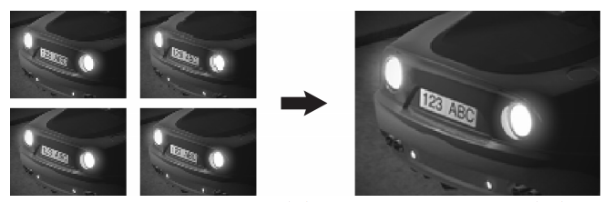

In [2]:
from IPython.display import Image
Image('img_src/preview.png')

There are many models widely used nowadays. Bicubic Interpolation, Deep Convolutional Neural Networks, Generative Adversarial Neural Networks and Pixel Recursive Super Resolution are most commonly used models. There are a few metrics to evaluate the model. MOS confirmed the superior perceptual performance of SRGAN using mean opinion score. PSNR standard quantitative measures peak signal-to-noise ratio. SSIM structural similarity. SSIM is used for measuring the similarity between two images. The SSIM index is a full reference metric; in other words, the measurement or prediction of image quality is based on an initial uncompressed or distortion-free image as reference. The most basic and the focus of this research is classification accuracy and training efficiency. The following image shows a comparison of different SR models. We can see image processed by bicubic model is blurry. PSNR of SRResNet and SRGAN are both high. And the SSIM of SRResNet and SRGAN are both good. 

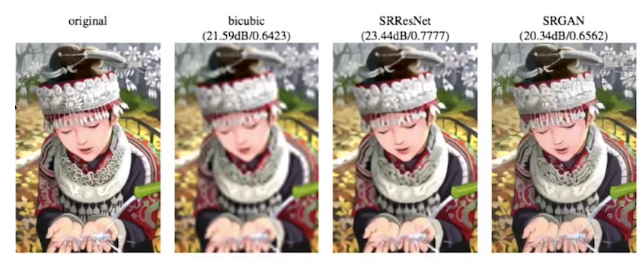

In [3]:
Image('img_src/modelCompare.png')

In this model, the model generates images using generator G and random noise. The model performs a batch update of weights in discriminator A given generated images, real images, and labels. Then the model performs a Batch update of weights in G given noise and forced “real” labels in the full GAN. 

## Experiment and results

### Import

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import confusion_matrix
import time
from datetime import timedelta
import math
import os
import prettytensor as pt
import mysql.connector
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
import csv
import datetime
import re
import statsmodels.api as sm
import mysql
from prettytable import PrettyTable
import itertools
from itertools import chain
from PIL import Image
import imagehash
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from PIL import Image
from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras import optimizers
import shutil

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
Using TensorFlow backend.


## Part1 Data Processing

### 1. Download dataset and store the label and image address information in a table of the data base created on Google Cloud Platform

#### Read labels from csv file and store it in label1

In [7]:
label1= pd.read_csv("trainLabels.csv", sep=',')

#### Create new dataframe with imageID, labelname, type and image address

In [3]:
list_col=['ImageID','LabelName','Type','ImageAddr']

In [4]:
df=pd.DataFrame(columns=list_col)

In [5]:
df['ImageID']=label1['id']
df['LabelName']=label1['label']
df['Type']=label1['id']

#### Split training data to 1:4

In [6]:
df.loc[df['ImageID']<=40000, 'Type'] = 'train'
df.loc[df['ImageID']>40000, 'Type'] = 'test'

In [7]:
# type in your local path for creating database on the cloud
path_local='/Users/lisha/Desktop/'

In [8]:
# this is for getting local image path
for i in range(len(df)):
    df.loc[i,'ImageAddr']=path_local + 'train/'+ str(i+1) +'.png'

#### Save the processed dataset to local txt file for creating database

In [11]:
df.to_csv(path_local+"ImageLabel.txt", sep=',',index=False, )

#### Open terminal to start proxy past this command: "./cloud_sql_proxy -instances=bd7245-200622:us-east1:image-category-184805=tcp:3306 &"

In [12]:
cnx = mysql.connector.connect(user='root', password='GoHusky!',
                              host='127.0.0.1',
                              database='ImageLabel')
c=cnx.cursor()

#### Create table with training and testing image information

In [97]:
sql = """CREATE TABLE ImageLabel_local (ImageID int NOT NULL, LabelName  CHAR(20) NOT NULL, Type CHAR(10) NOT NULL, ImageAddr CHAR(255) NOT NULL)"""
c.execute(sql)

#### Load data to the cloud with the file just created

In [100]:
query = "LOAD DATA LOCAL INFILE '/Users/lisha/Desktop/ImageLabel.txt' INTO TABLE ImageLabel_local FIELDS TERMINATED BY ','  Lines Terminated BY '\n' (ImageID,LabelName,Type,ImageAddr)"
c.execute( query )
cnx.commit()

In [13]:
# A function to print returned data in a better form
def print_table(c):
    rows=c.fetchall()
    pt = PrettyTable([i[0] for i in c.description])
    pt.align= "l"
    for row in rows:
        pt.add_row(row)
    print (pt)

In [14]:
# Database I created
c.execute("""SELECT * FROM ImageLabel_local LIMIT 10""")
print_table(c)

+---------+------------+-------+----------------------------------+
| ImageID | LabelName  | Type  | ImageAddr                        |
+---------+------------+-------+----------------------------------+
| 0       | LabelName  | Type  | ImageAddr                        |
| 1       | frog       | train | /Users/lisha/Desktop/train/1.png |
| 2       | truck      | train | /Users/lisha/Desktop/train/2.png |
| 3       | truck      | train | /Users/lisha/Desktop/train/3.png |
| 4       | deer       | train | /Users/lisha/Desktop/train/4.png |
| 5       | automobile | train | /Users/lisha/Desktop/train/5.png |
| 6       | automobile | train | /Users/lisha/Desktop/train/6.png |
| 7       | bird       | train | /Users/lisha/Desktop/train/7.png |
| 8       | horse      | train | /Users/lisha/Desktop/train/8.png |
| 9       | ship       | train | /Users/lisha/Desktop/train/9.png |
+---------+------------+-------+----------------------------------+


### 2. Process data to suitable set for tensorflow

In [15]:
# This function is used to de-tuple list of tuples
def tuple_list(tuplelist):
    return list(itertools.chain(*tuplelist))

#### Get images and label lists with label name cat&dog

In [16]:
c=cnx.cursor()
c.execute("""SELECT LabelName FROM ImageLabel_local WHERE LabelName='cat' OR LabelName='dog'""")
list_label_cat_dog=tuple_list(c.fetchall())

In [17]:
c=cnx.cursor()
c.execute("""SELECT ImageAddr FROM ImageLabel_local WHERE LabelName='cat' OR LabelName='dog'""")
list_file_cat_dog=tuple_list(c.fetchall())

#### Get cifar2 from training images downloaded from https://www.cs.toronto.edu/~kriz/cifar.html

In [18]:
import cifar10
import helper
from dataset import one_hot_encoded

#### Set image size, chanels, cropped image size, and classes of images

In [19]:
img_size=32
num_channels=3
num_classes=10
img_size_cropped=32

In [20]:
list_label_cat_dog[:5]

['cat', 'cat', 'cat', 'cat', 'dog']

#### Change names of class to numbers 0 to 9, here cat is 3 and dog is 5

In [21]:
for i in range(len(list_label_cat_dog)):
    if list_label_cat_dog[i]=='cat':
        list_label_cat_dog[i]=3
    else:
        list_label_cat_dog[i]=5

In [22]:
cls2=np.array(list_label_cat_dog)

In [23]:
list_file_cat_dog[:5]

['/Users/lisha/Desktop/train/10.png',
 '/Users/lisha/Desktop/train/18.png',
 '/Users/lisha/Desktop/train/22.png',
 '/Users/lisha/Desktop/train/27.png',
 '/Users/lisha/Desktop/train/28.png']

#### Get images and labels for the training set.

In [24]:
list_raw=[]
for image in list_file_cat_dog:
    img = Image.open(image)
    data = list(img.getdata())
    list_raw.append(tuple_list(data))

In [25]:
raw_images=np.array(list_raw)
images2 = cifar10._convert_images(raw_images)
images_train=images2

In [26]:
labels_train=one_hot_encoded(class_numbers=cls2, num_classes=num_classes)

#### Get test data set from cifar10

In [27]:
images_test, cls_test, labels_test = cifar10.load_test_data()

Loading data: data/CIFAR-10/cifar-10-batches-py/test_batch


#### The CIFAR-10 data-set has now been loaded and consists of 60,000 images and associated labels (i.e. classifications of the images). The data-set is split into 2 mutually exclusive sub-sets, the training-set and the test-set.

In [28]:
l=list(images_test)
l1=list(labels_test)
l2=list(cls_test)

In [29]:
t=pd.DataFrame({'img':l, 'lab':l1, 'cls': l2})

In [30]:
t1=t.loc[t['cls'] == 3]
t2=t.loc[t['cls'] == 5]
frame=pd.concat([t1,t2])

In [31]:
img_test=np.array(list(frame['img']))
lab_test=np.array(list(frame['lab']))
cl_test=np.array(list(frame['cls']))

In [8]:
# this is a function to change the contrast of image
def change_contrast(img, level):
    img=Image.fromarray(img, 'RGB')
    factor = (259 * (level + 255)) / (255 * (259 - level))
    def contrast(c):
        return 128 + factor * (c - 128)
    return img.point(contrast)

#### Get the change-contrasted image dataset from original dataset

In [33]:
list_distorted=[]
for img in img_test:
    list_distorted.append(change_contrast(img,300))

#### Convert image dataset to fit the training using cifar10._convert_images(img)

In [34]:
list_dis=[]
for i in range(len(list_distorted)):
    im = list_distorted[i]
    pixels = tuple_list(list(im.getdata()))
    list_dis.append(pixels)
raw_images_test_distorted=np.array(list_dis)
images_test_distorted=cifar10._convert_images(raw_images_test_distorted)

#### For fast getting cifar2, move images labeled dog and cat to another folder named train_processed

In [144]:
for addr in list_file_cat_dog:
    src = addr
    dst = "/Users/lisha/Desktop/train_processed/"
    shutil.move(src, dst)

## Part 2 Build a CNN model using tensorflow

### Helper-function for creating Main Processing¶
The following helper-function creates the main part of the convolutional neural network. 

In [35]:
def main_network(images, training):
    x_pretty = pt.wrap(images)
    if training:
        phase = pt.Phase.train
    else:
        phase = pt.Phase.infer        
    with pt.defaults_scope(activation_fn=tf.nn.relu, phase=phase):
        y_pred, loss = x_pretty.\
            conv2d(kernel=5, depth=64, name='layer_conv1', batch_normalize=True).\
            max_pool(kernel=2, stride=2).\
            conv2d(kernel=5, depth=64, name='layer_conv2').\
            max_pool(kernel=2, stride=2).\
            flatten().\
            fully_connected(size=256, name='layer_fc1').\
            fully_connected(size=128, name='layer_fc2').\
            softmax_classifier(num_classes=num_classes, labels=y_true)
    return y_pred, loss

In [36]:
def create_network(training):
    with tf.variable_scope('network', reuse=tf.AUTO_REUSE):
        images = x
        images = pre_process(images=images)
        y_pred, loss = main_network(images=images, training=training)

    return y_pred, loss

### Helper-function for creating Pre-Processing
The following helper-functions create the part of the TensorFlow computational graph that pre-processes the input images. Nothing is actually calculated at this point, the function merely adds nodes to the computational graph for TensorFlow.

The pre-processing is different for training and testing of the neural network:

For training, the input images are randomly cropped, randomly flipped horizontally, and the hue, contrast and saturation is adjusted with random values. This artificially inflates the size of the training-set by creating random variations of the original input images. Examples of distorted images are shown further below.

For testing, the input images are cropped around the centre and nothing else is adjusted.

In [37]:
def pre_process_image(image):
    image = tf.random_crop(image, size=[img_size_cropped, img_size_cropped, num_channels])
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_hue(image, max_delta=0.05)
    image = tf.image.random_contrast(image, lower=0.3, upper=1.0)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.image.random_saturation(image, lower=0.0, upper=2.0)
    image = tf.minimum(image, 1.0)
    image = tf.maximum(image, 0.0)
    return image
def pre_process(images):
    images = tf.map_fn(lambda image: pre_process_image(image), images)
    return images
def predict_cls(images, labels, cls_true):
    num_images = len(images)
    cls_pred = np.zeros(shape=num_images, dtype=np.int)
    i = 0
    while i < num_images:
        j = min(i + batch_size, num_images)
        feed_dict = {x: images[i:j, :],y_true: labels[i:j, :]}
        cls_pred[i:j] = session.run(y_pred_cls, feed_dict=feed_dict)
        i = j
    correct = (cls_true == cls_pred)    
    return correct, cls_pred
def get_test_acc(batch_size, images_test):
    correct, cls_pred = predict_cls(images = images_test, labels = lab_test, cls_true = cl_test)
    acc, num_correct = correct.mean(), correct.sum()
    num_images = len(correct)
    msg = "Accuracy on Test-Set: {0:.1%} ({1} / {2})"
    print(msg.format(acc, num_correct, num_images))
    return acc

### Helper-function for creating Neural Network
The following helper-function creates the full neural network, which consists of the pre-processing and main-processing defined above.

Note that the neural network is enclosed in the variable-scope named 'network'. This is because we are actually creating two neural networks in the TensorFlow graph. By assigning a variable-scope like this, we can re-use the variables for the two neural networks, so the variables that are optimized for the training-network are re-used for the other network that is used for testing.

In [38]:
def get_weights_variable(layer_name):
    # Retrieve an existing variable named 'weights' in the scope
    # with the given layer_name.
    # This is awkward because the TensorFlow function was
    # really intended for another purpose.

    with tf.variable_scope("network/" + layer_name, reuse=True):
        variable = tf.get_variable('weights')

    return variable
def get_acc(train_batch_size, images_train, labels_train):
    start_time = time.time()
    RUN=True
    l_accuracy=[]
    l_step=[]
    l_time=[]
    batch_acc=0
    for i in range(num_iterations):
        #w1=get_weights_variable(layer_name='layer_conv1')
        #w2=get_weights_variable(layer_name='layer_conv2')
        tf.summary.scalar('accuracy', accuracy)
        #tf.summary.histogram('weights1',w1)
        #tf.summary.histogram('weights2',w2)
        x_batch, y_true_batch = helper.random_batch(train_batch_size, images_train, labels_train)
        feed_dict_train = {x: x_batch, y_true: y_true_batch}
        i_global, _ = session.run([global_step, optimizer], feed_dict=feed_dict_train)#global step
        
        if (i_global % 100 == 0) or (i == num_iterations - 1):
            batch_acc = session.run(accuracy, feed_dict=feed_dict_train)
            msg = "Global Step: {0:>6}, Training Batch Accuracy: {1:>6.1%}"
            print(msg.format(i_global, batch_acc))
            s=session.run(summary, feed_dict=feed_dict_train)
            summary_writer.add_summary(s,i)
               
        l_accuracy.append(batch_acc)
        l_step.append(i_global)
        l_time.append(time.time())
        
    end_time = time.time()
    time_dif = end_time - start_time
    print("Time usage: " + str(timedelta(seconds=int(round(time_dif)))))
    return l_accuracy, l_step, time_dif, l_time

### 1. Train the CNN model and optimize variables during traing.

### TensorFlow Graph
The entire purpose of TensorFlow is to have a so-called computational graph that can be executed much more efficiently than if the same calculations were to be performed directly in Python. TensorFlow can be more efficient than NumPy because TensorFlow knows the entire computation graph that must be executed, while NumPy only knows the computation of a single mathematical operation at a time.

TensorFlow can also automatically calculate the gradients that are needed to optimize the variables of the graph so as to make the model perform better. This is because the graph is a combination of simple mathematical expressions so the gradient of the entire graph can be calculated using the chain-rule for derivatives.

TensorFlow can also take advantage of multi-core CPUs as well as GPUs - and Google has even built special chips just for TensorFlow which are called TPUs (Tensor Processing Units) and are even faster than GPUs.

A TensorFlow graph consists of the following parts which will be detailed below:

* Placeholder variables used for inputting data to the graph.
* Variables that are going to be optimized so as to make the convolutional network perform better.
* The mathematical formulas for the convolutional network.
* A loss measure that can be used to guide the optimization of the variables.
* An optimization method which updates the variables.

In addition, the TensorFlow graph may also contain various debugging statements e.g. for logging data to be displayed using TensorBoard, which is not covered in this tutorial.

In [515]:
# this is the path to store your tensor board
path_board='/Users/lisha/Desktop/tensor_board/'

In [516]:
# training batch size and number of iterations
train_batch_size = 64
num_iterations=10000

#### remember to reset graph every time before you create a new one

In [517]:
tf.reset_default_graph()

### Placeholder variables
Placeholder variables serve as the input to the TensorFlow computational graph that we may change each time we execute the graph. We call this feeding the placeholder variables and it is demonstrated further below.

First we define the placeholder variable for the input images. This allows us to change the images that are input to the TensorFlow graph. This is a so-called tensor, which just means that it is a multi-dimensional array. The data-type is set to float32 and the shape is set to [None, img_size, img_size, num_channels], where None means that the tensor may hold an arbitrary number of images with each image being img_size pixels high and img_size pixels wide and with num_channels colour channels.

In [518]:
x = tf.placeholder(tf.float32, shape=[None, img_size, img_size, num_channels], name='x')
y_true = tf.placeholder(tf.float32, shape=[None, num_classes], name='y_true')
y_true_cls = tf.argmax(y_true, dimension=1)

### Create Neural Network for Training Phase
First create a TensorFlow variable that keeps track of the number of optimization iterations performed so far. In the previous tutorials this was a Python variable, but in this tutorial we want to save this variable with all the other TensorFlow variables in the checkpoints.

Note that trainable=False which means that TensorFlow will not try to optimize this variable.

### Create Neural Network for Test Phase / Inference
Now create the neural network for the test-phase. Once again the create_network() function returns the predicted class-labels y_pred for the input images, as well as the loss-function to be used during optimization. During testing we only need y_pred.

In [519]:
global_step = tf.Variable(initial_value=0, name='global_step')
_, loss = create_network(training=True)
with tf.name_scope('train'):
    optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(loss, global_step=global_step)
y_pred, _ = create_network(training=False)
#We then calculate the predicted class number as an integer. The output of the network y_pred is an array with 10 elements. The class number is the index of the largest element in the array.
y_pred_cls = tf.argmax(y_pred, dimension=1)
#Then we create a vector of booleans telling us whether the predicted class equals the true class of each image.
with tf.name_scope('accuracy'):
    correct_prediction = tf.equal(y_pred_cls, y_true_cls)
#The classification accuracy is calculated by first type-casting the vector of booleans to floats, so that False becomes 0 and True becomes 1, and then taking the average of these numbers.
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

#Once the TensorFlow graph has been created, we have to create a TensorFlow session which is used to execute the graph.
session = tf.Session()


### Initialize the model
The activation function is Relu. To improve the accuracy I initialize bias and weights with: 
w = tf.Variable(tf.truncated_normal([5,5,3,64], stddev=0.1),name="w")
b = tf.Variable(tf.constant(0.1,shape=[64]), name="b")

In [520]:
w = tf.Variable(tf.truncated_normal([5,5,3,64], stddev=0.1),name="w")
b = tf.Variable(tf.constant(0.1,shape=[64]), name="b")

In [521]:
init_op = tf.global_variables_initializer()
session.run(init_op)

### Keep record of the training using tensor board
TensorBoard is a suite of web applications for inspecting and understanding your TensorFlow runs and graphs. TensorBoard currently supports five visualizations: scalars, images, audio, histograms, and graphs. The computations you will use in TensorFlow for things such as training a massive deep neural network, can be fairly complex and confusing, TensorBoard will make this a lot easier to understand, debug, and optimize your TensorFlow programs.

visit tensor board: open a terminal --> tensorboard --logdir=path/to/your/tensorboard--> open browser localhost:6006

In [522]:
summary = tf.summary.merge_all()
summary_writer = tf.summary.FileWriter(path_board+'original_1')
summary_writer.add_graph(session.graph)

### The graph overview

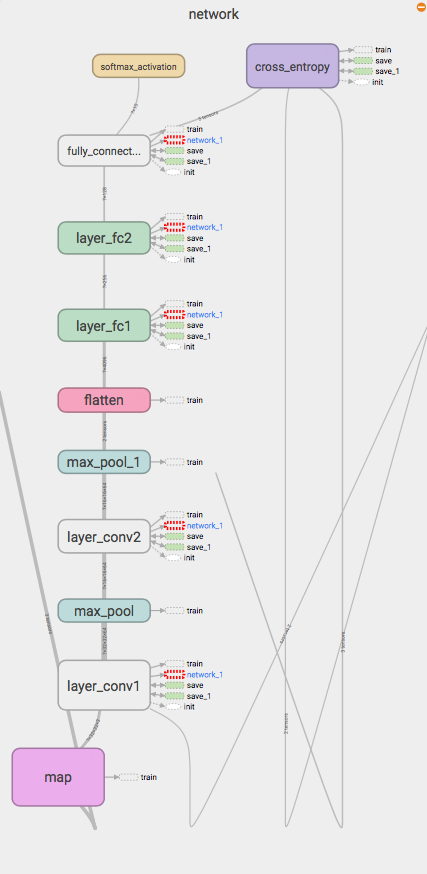

In [11]:
from IPython.display import Image
Image('img_src/graph.png')

### Start Training and keep record of time accuracy and steps

In [523]:
l_acc_1, l_step_1, t_diff_1, l_time_1=get_acc(train_batch_size=train_batch_size, images_train=images_train, labels_train=labels_train)

Global Step:    100, Training Batch Accuracy:  67.2%
Global Step:    200, Training Batch Accuracy:  65.6%
Global Step:    300, Training Batch Accuracy:  57.8%
Global Step:    400, Training Batch Accuracy:  59.4%
Global Step:    500, Training Batch Accuracy:  62.5%
Global Step:    600, Training Batch Accuracy:  62.5%
Global Step:    700, Training Batch Accuracy:  53.1%
Global Step:    800, Training Batch Accuracy:  45.3%
Global Step:    900, Training Batch Accuracy:  64.1%
Global Step:   1000, Training Batch Accuracy:  53.1%
Global Step:   1100, Training Batch Accuracy:  64.1%
Global Step:   1200, Training Batch Accuracy:  68.8%
Global Step:   1300, Training Batch Accuracy:  53.1%
Global Step:   1400, Training Batch Accuracy:  71.9%
Global Step:   1500, Training Batch Accuracy:  48.4%
Global Step:   1600, Training Batch Accuracy:  65.6%
Global Step:   1700, Training Batch Accuracy:  57.8%
Global Step:   1800, Training Batch Accuracy:  68.8%
Global Step:   1900, Training Batch Accuracy: 

### Monitor the training process with tensorboard. 
The average accuracy cross entropy is approaching 0.24.
The loss of cross entropy is approaching 0.3

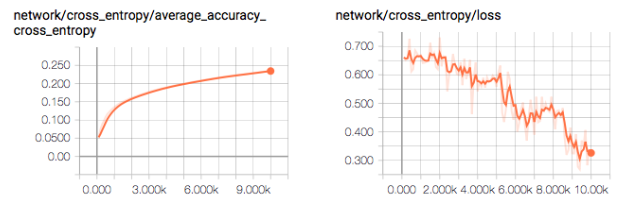

In [22]:
Image("img_src/tensorBorad1.png")

### 2. Get test accuracy

In [525]:
batch_size = 256 
t1=get_test_acc(batch_size=batch_size, images_test=img_test)

Accuracy on Test-Set: 54.6% (1092 / 2000)


### 3. Get accuracy of distorted images

In [532]:
batch_size = 256 
t_t=get_test_acc(batch_size=batch_size,images_test=images_test_distorted)

Accuracy on Test-Set: 49.6% (993 / 2000)


## Part3 Exploring possibility of using single image super resolution in image classification

### 1. Build a GAN model 

### Import

In [39]:
from keras.datasets import mnist
from keras.datasets import cifar10
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
import tensorflow as tf
from scipy.misc import imread, imsave
import matplotlib.pyplot as plt
import sys
import os
from PIL import Image
from glob import glob
import numpy as np

### Generative Adverserial Network
* Generator
The input to the generator is a series of randomly generated numbers called latent sample. Once trained, the generator can produce digit images from latent samples.
* Discriminator
The discriminator is a classifier trained using the supervised learning. It classifies whether an image is real (1) or not (0).

The work flow is shown in the image below

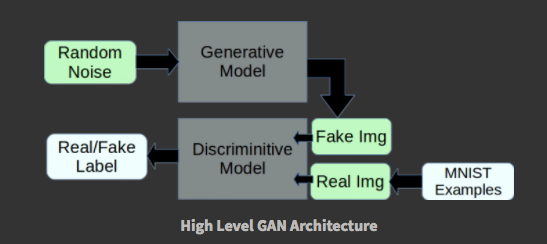

In [12]:
Image('img_src/flow.png')

### Helper funtions to build generator

In [40]:
def build_generator():

    noise_shape = (100,)
        
    model = Sequential()

    model.add(Dense(256, input_shape=noise_shape))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(1024))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(np.prod(img_shape), activation='tanh'))
    model.add(Reshape(img_shape))

    model.summary()

    noise = Input(shape=noise_shape)
    img = model(noise)

    return Model(noise, img)

### Helper funtion to build discriminator

In [41]:
def build_discriminator():

    img_shape = (img_rows, img_cols, channels)
        
    model = Sequential()

    model.add(Flatten(input_shape=img_shape))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(256))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(1, activation='sigmoid'))
    model.summary()

    img = Input(shape=img_shape)
    validity = model(img)

    return Model(img, validity)

### Helper function to get image set
this function will open image and pre-process them to the assigned size

In [42]:
def get_image(image_path, width, height, mode):
    
    image = Image.open(image_path)
    # image = image.resize([width, height], Image.BILINEAR)
    if image.size != (width, height):  
    # Remove most pixels that aren't part of a face
        face_width = face_height = 108
        j = (image.size[0] - face_width) // 2
        i = (image.size[1] - face_height) // 2
        image = image.crop([j, i, j + face_width, i + face_height])
        image = image.resize([width, height])
    
    return np.array(image.convert(mode))

### Helper function to get image batch ramdomly

In [43]:
def get_batch(image_files, width, height, mode):
    data_batch = np.array(
            [get_image(sample_file, width, height, mode) for sample_file in image_files])
    return data_batch  

### Helper function to save training images
this function will select 25 image randomly from the training set<br>
result will be saved local path<br>
the image will show in a format of 5X5

In [58]:
def save_imgs(epoch):
    r, c = 5, 5
    noise1 = np.random.normal(0, 1, (r * c, 100))
    gen_imgs1 = generator.predict(noise1)

    # Rescale images 0 - 1
    gen_imgs1 = (1/2.5) * gen_imgs1 + 0.5

    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i,j].imshow(gen_imgs1[cnt, :,:,:])
            axs[i,j].axis('off')
            cnt += 1
    fig.savefig("output/%d.png" % epoch)
    plt.close()

### The optimizor and image shape
Optimizor will be Adam(0.0002, 0.5)<br>
Single input shape will be 32x32x3

In [59]:
img_rows = 32 
img_cols = 32
channels = 3
img_shape = (img_rows, img_cols, channels)

optimizer = Adam(0.0002, 0.5)

### Build and compile the discriminator

In [60]:
discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy', 
            optimizer=optimizer,
            metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 3072)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 512)               1573376   
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 257       
Total params: 1,704,961
Trainable params: 1,704,961
Non-trainable params: 0
_________________________________________________________________


### Build and compile the generator

In [61]:
generator = build_generator()
generator.compile(loss='binary_crossentropy', optimizer=optimizer)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 256)               25856     
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 256)               1024      
_________________________________________________________________
dense_12 (Dense)             (None, 512)               131584    
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 512)               2048      
_________________________________________________________________
dense_13 (Dense)             (None, 1024)              525312    
__________

#### The generator takes noise as input and generated imgs

In [62]:
z = Input(shape=(100,))
img = generator(z)

#### For the combined model we will only train the generator

In [63]:
discriminator.trainable = False

#### The valid takes generated images as input and determines validity

In [64]:
valid = discriminator(img)

#### The combined model  (stacked generator and discriminator) takes
#### noise as input => generates images => determines validity 

In [65]:
combined = Model(z, valid)
combined.compile(loss='binary_crossentropy', optimizer=optimizer)

#### Set ephochs, batch size and save image interval

In [75]:
epochs=10000
batch_size=32
save_interval=200

#### This part is for creating images for training
the image will be set to 32x32<br>
training set will be transfered to 1 and 0

In [67]:
data_dir = '/Users/lisha/Desktop/train_processed'
X_train = get_batch(glob(os.path.join(data_dir, '*.png')), 32, 32, 'RGB')

#Rescale -1 to 1
X_train = (X_train.astype(np.float32) - 127.5) / 127.5

half_batch = int(batch_size / 2)
#Create lists for logging the losses
d_loss_logs_r = []
d_loss_logs_f = []
g_loss_logs = []

In [68]:
X_train.shape

(10000, 32, 32, 3)

### Helper function to train the GAN model

In [98]:
def train_gan(epochs, batch_size, save_interval):
    start_time = time.time()
    for epoch in range(epochs):

        # ---------------------
        #  Train Discriminator
        # ---------------------

        # Select a random half batch of images
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        imgs = X_train[idx]

        noise = np.random.normal(0, 1, (batch_size, 100))

        # Generate a half batch of new images
        gen_imgs = generator.predict(noise)

        # Train the discriminator
        d_loss_real = discriminator.train_on_batch(imgs, np.ones((batch_size, 1)))
        d_loss_fake = discriminator.train_on_batch(gen_imgs, np.zeros((batch_size, 1)))
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)


        # ---------------------
        #  Train Generator
        # ---------------------

        noise = np.random.normal(0, 1, (batch_size, 100))

        # The generator wants the discriminator to label the generated samples
        # as valid (ones)
        valid_y = np.array([1] * batch_size)
    
        # Train the generator
        g_loss = combined.train_on_batch(noise, valid_y)

        # Plot the progress
        if epoch % 100 == 0:
            print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

        #Append the logs with the loss values in each training step
        d_loss_logs_r.append([epoch, d_loss[0]])
        d_loss_logs_f.append([epoch, d_loss[1]])
        g_loss_logs.append([epoch, g_loss])

        # If at save interval => save generated image samples
        if epoch % save_interval == 0:
            save_imgs(epoch)
    end_time = time.time()
    time_dif = end_time - start_time
    print("Time usage: " + str(timedelta(seconds=int(round(time_dif)))))
    
    #Convert the log lists to numpy arrays
    d_loss_logs_r_a = np.array(d_loss_logs_r)
    d_loss_logs_f_a = np.array(d_loss_logs_f)
    g_loss_logs_a = np.array(g_loss_logs)

    #Generate the plot at the end of training
    plt.plot(d_loss_logs_r_a[:,0], d_loss_logs_r_a[:,1], label="Discriminator Loss - Real")
    plt.plot(d_loss_logs_f_a[:,0], d_loss_logs_f_a[:,1], label="Discriminator Loss - Fake")
    plt.plot(g_loss_logs_a[:,0], g_loss_logs_a[:,1], label="Generator Loss")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Variation of losses over epochs')
    plt.grid(True)
    plt.show()     

### Train the GAN model
In this part, I will keep using cifar2 to train and get processed data during training. 

/anaconda3/lib/python3.6/site-packages/keras/engine/training.py:973: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [D loss: 0.662717, acc.: 68.75%] [G loss: 1.155978]
100 [D loss: 0.662264, acc.: 56.25%] [G loss: 1.110256]
200 [D loss: 0.678120, acc.: 65.62%] [G loss: 1.277733]
300 [D loss: 0.637166, acc.: 57.81%] [G loss: 1.171204]
400 [D loss: 0.657644, acc.: 57.81%] [G loss: 1.203775]
500 [D loss: 0.651813, acc.: 62.50%] [G loss: 1.183848]
600 [D loss: 0.641256, acc.: 64.06%] [G loss: 1.096395]
700 [D loss: 0.635987, acc.: 60.94%] [G loss: 1.304063]
800 [D loss: 0.543803, acc.: 70.31%] [G loss: 1.480361]
900 [D loss: 0.519944, acc.: 79.69%] [G loss: 1.787801]
1000 [D loss: 0.480902, acc.: 82.81%] [G loss: 2.192204]
1100 [D loss: 0.433406, acc.: 82.81%] [G loss: 2.283368]
1200 [D loss: 0.587161, acc.: 65.62%] [G loss: 2.391045]
1300 [D loss: 0.382405, acc.: 82.81%] [G loss: 2.165802]
1400 [D loss: 0.330081, acc.: 89.06%] [G loss: 2.820564]
1500 [D loss: 0.324153, acc.: 90.62%] [G loss: 3.459948]
1600 [D loss: 0.381477, acc.: 82.81%] [G loss: 2.696252]
1700 [D loss: 0.344325, acc.: 89.06%] [G lo

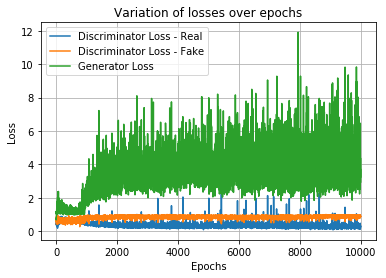

Time usage: 0:41:09


In [77]:
train_gan(epochs=10000, batch_size=32, save_interval=200)

### Outcomes
After training for  41 minutes and 10k steps. The training accuracy is around 90%.<br>
And below is the comparison of image0 and image 9800

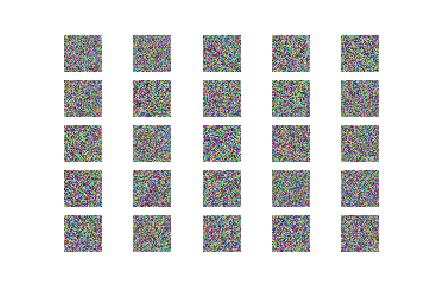

In [14]:
Image("img_src/0.png")

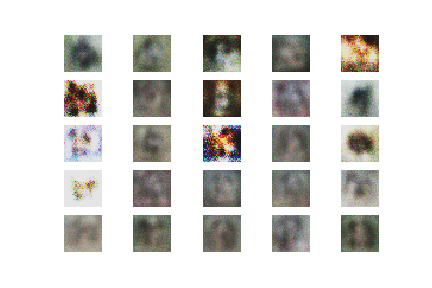

In [15]:
Image("img_src/9800.png")

#### Save image to another location

In [99]:
def save_imgs(epoch):
    r, c = 5, 5
    noise1 = np.random.normal(0, 1, (r * c, 100))
    gen_imgs1 = generator.predict(noise1)

    # Rescale images 0 - 1
    gen_imgs1 = (1/2.5) * gen_imgs1 + 0.5

    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i,j].imshow(gen_imgs1[cnt, :,:,:])
            axs[i,j].axis('off')
            cnt += 1
    fig.savefig("output/5/%d.png" % epoch)
    plt.close()

#### increase training ephochs to get better accuracy and image resolution

In [100]:
epochs=50000
batch_size=32
save_interval=200

/anaconda3/lib/python3.6/site-packages/keras/engine/training.py:973: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [D loss: 0.176262, acc.: 96.88%] [G loss: 2.337580]
100 [D loss: 0.231024, acc.: 92.19%] [G loss: 4.095082]
200 [D loss: 0.181815, acc.: 95.31%] [G loss: 4.480131]
300 [D loss: 0.193506, acc.: 93.75%] [G loss: 4.250412]
400 [D loss: 0.367328, acc.: 84.38%] [G loss: 4.674867]
500 [D loss: 0.215465, acc.: 90.62%] [G loss: 2.769266]
600 [D loss: 0.255955, acc.: 90.62%] [G loss: 5.245602]
700 [D loss: 0.235468, acc.: 89.06%] [G loss: 4.044633]
800 [D loss: 0.261202, acc.: 87.50%] [G loss: 4.419530]
900 [D loss: 0.461127, acc.: 81.25%] [G loss: 3.209883]
1000 [D loss: 0.244498, acc.: 87.50%] [G loss: 5.169482]
1100 [D loss: 0.320265, acc.: 85.94%] [G loss: 4.102770]
1200 [D loss: 0.305988, acc.: 89.06%] [G loss: 3.346129]
1300 [D loss: 0.149311, acc.: 95.31%] [G loss: 2.541819]
1400 [D loss: 0.343116, acc.: 82.81%] [G loss: 3.892356]
1500 [D loss: 0.294862, acc.: 85.94%] [G loss: 3.128893]
1600 [D loss: 0.172289, acc.: 98.44%] [G loss: 3.244930]
1700 [D loss: 0.364343, acc.: 85.94%] [G lo

14400 [D loss: 0.245006, acc.: 90.62%] [G loss: 5.225935]
14500 [D loss: 0.247370, acc.: 90.62%] [G loss: 6.038684]
14600 [D loss: 0.152176, acc.: 93.75%] [G loss: 4.325384]
14700 [D loss: 0.305962, acc.: 85.94%] [G loss: 3.268875]
14800 [D loss: 0.311993, acc.: 85.94%] [G loss: 3.620763]
14900 [D loss: 0.264474, acc.: 87.50%] [G loss: 4.769238]
15000 [D loss: 0.183828, acc.: 93.75%] [G loss: 4.943093]
15100 [D loss: 0.275455, acc.: 87.50%] [G loss: 4.667504]
15200 [D loss: 0.183496, acc.: 89.06%] [G loss: 3.264858]
15300 [D loss: 0.189833, acc.: 93.75%] [G loss: 3.774892]
15400 [D loss: 0.274558, acc.: 89.06%] [G loss: 3.680691]
15500 [D loss: 0.216560, acc.: 92.19%] [G loss: 3.735717]
15600 [D loss: 0.364759, acc.: 79.69%] [G loss: 3.518442]
15700 [D loss: 0.277906, acc.: 87.50%] [G loss: 5.876400]
15800 [D loss: 0.274305, acc.: 85.94%] [G loss: 6.487573]
15900 [D loss: 0.170969, acc.: 93.75%] [G loss: 4.139155]
16000 [D loss: 0.201600, acc.: 87.50%] [G loss: 4.573945]
16100 [D loss:

28600 [D loss: 0.381432, acc.: 85.94%] [G loss: 5.714877]
28700 [D loss: 0.313978, acc.: 84.38%] [G loss: 3.226219]
28800 [D loss: 0.246030, acc.: 89.06%] [G loss: 3.564480]
28900 [D loss: 0.318713, acc.: 84.38%] [G loss: 3.454271]
29000 [D loss: 0.436011, acc.: 85.94%] [G loss: 4.790264]
29100 [D loss: 0.210170, acc.: 89.06%] [G loss: 3.789899]
29200 [D loss: 0.241154, acc.: 89.06%] [G loss: 3.849093]
29300 [D loss: 0.450773, acc.: 73.44%] [G loss: 4.672487]
29400 [D loss: 0.282385, acc.: 84.38%] [G loss: 2.576083]
29500 [D loss: 0.527492, acc.: 73.44%] [G loss: 4.958017]
29600 [D loss: 0.306380, acc.: 89.06%] [G loss: 4.853641]
29700 [D loss: 0.306092, acc.: 85.94%] [G loss: 4.777597]
29800 [D loss: 0.224600, acc.: 93.75%] [G loss: 4.446228]
29900 [D loss: 0.384896, acc.: 81.25%] [G loss: 3.033813]
30000 [D loss: 0.193397, acc.: 89.06%] [G loss: 4.519112]
30100 [D loss: 0.171765, acc.: 93.75%] [G loss: 7.157044]
30200 [D loss: 0.238866, acc.: 85.94%] [G loss: 5.857572]
30300 [D loss:

42800 [D loss: 0.267167, acc.: 89.06%] [G loss: 5.387749]
42900 [D loss: 0.228826, acc.: 92.19%] [G loss: 3.508644]
43000 [D loss: 0.362104, acc.: 82.81%] [G loss: 4.159830]
43100 [D loss: 0.241396, acc.: 87.50%] [G loss: 4.117987]
43200 [D loss: 0.213266, acc.: 90.62%] [G loss: 3.137733]
43300 [D loss: 0.242689, acc.: 87.50%] [G loss: 3.679409]
43400 [D loss: 0.310111, acc.: 84.38%] [G loss: 3.390781]
43500 [D loss: 0.485324, acc.: 75.00%] [G loss: 4.497387]
43600 [D loss: 0.437284, acc.: 78.12%] [G loss: 2.331325]
43700 [D loss: 0.321233, acc.: 89.06%] [G loss: 3.070861]
43800 [D loss: 0.492408, acc.: 79.69%] [G loss: 5.901153]
43900 [D loss: 0.201665, acc.: 92.19%] [G loss: 3.880442]
44000 [D loss: 0.227803, acc.: 93.75%] [G loss: 3.495388]
44100 [D loss: 1.118756, acc.: 73.44%] [G loss: 3.499524]
44200 [D loss: 0.340781, acc.: 87.50%] [G loss: 3.869915]
44300 [D loss: 0.297508, acc.: 85.94%] [G loss: 4.120282]
44400 [D loss: 0.242801, acc.: 87.50%] [G loss: 5.464738]
44500 [D loss:

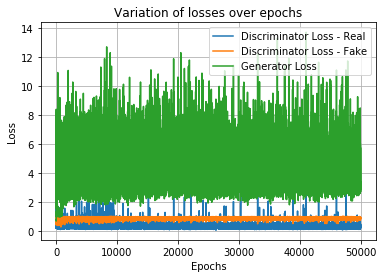

In [101]:
train_gan(epochs=50000, batch_size=32, save_interval=200)

### Outcomes
After training for 3 hours and 50k steps. The training accuracy is around 90%.<br>
And below is the comparison of image9800 and final image.<br>
We can see what is in the images now.

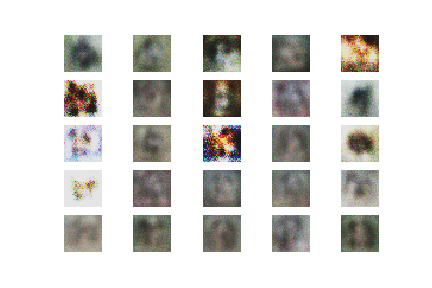

In [17]:
Image("img_src/9800.png")

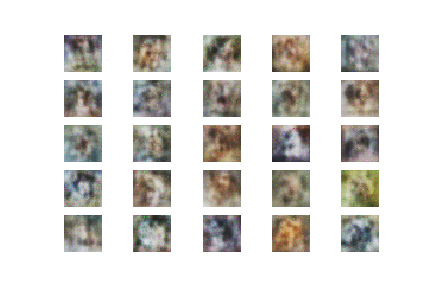

In [19]:
Image("img_src/40.png")

#### change save image path

In [102]:
def save_imgs(epoch):
    r, c = 5, 5
    noise1 = np.random.normal(0, 1, (r * c, 100))
    gen_imgs1 = generator.predict(noise1)

    # Rescale images 0 - 1
    gen_imgs1 = (1/2.5) * gen_imgs1 + 0.5

    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i,j].imshow(gen_imgs1[cnt, :,:,:])
            axs[i,j].axis('off')
            cnt += 1
    fig.savefig("output/5/%d.png" % epoch)
    plt.close()

### Helper function to generate training set
Because the cifar2 dataset has 10k images, set the batch_size to 10k.

In [103]:
def train_gan(epochs, batch_size, save_interval):
    start_time = time.time()
    for epoch in range(epochs):

        # ---------------------
        #  Train Discriminator
        # ---------------------

        # Select a random half batch of images
        idx = np.random.randint(0, X_train.shape[0], 10000)
        imgs = X_train[idx]

        noise = np.random.normal(0, 1, (10000, 100))

        # Generate a half batch of new images
        gen_imgs = generator.predict(noise)
        return_value=gen_imgs

        # Train the discriminator
        d_loss_real = discriminator.train_on_batch(imgs, np.ones((10000, 1)))
        d_loss_fake = discriminator.train_on_batch(gen_imgs, np.zeros((10000, 1)))
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)


        # ---------------------
        #  Train Generator
        # ---------------------

        noise = np.random.normal(0, 1, (10000, 100))

        # The generator wants the discriminator to label the generated samples
        # as valid (ones)
        valid_y = np.array([1] * 10000)
    
        # Train the generator
        g_loss = combined.train_on_batch(noise, valid_y)

        # Plot the progress
        if epoch % 10 == 0:
            print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

        #Append the logs with the loss values in each training step
        d_loss_logs_r.append([epoch, d_loss[0]])
        d_loss_logs_f.append([epoch, d_loss[1]])
        g_loss_logs.append([epoch, g_loss])

        # If at save interval => save generated image samples
        if epoch % save_interval == 0:
            save_imgs(epoch)
    end_time = time.time()
    time_dif = end_time - start_time
    print("Time usage: " + str(timedelta(seconds=int(round(time_dif)))))
    #Convert the log lists to numpy arrays
    d_loss_logs_r_a = np.array(d_loss_logs_r)
    d_loss_logs_f_a = np.array(d_loss_logs_f)
    g_loss_logs_a = np.array(g_loss_logs)

    #Generate the plot at the end of training
    plt.plot(d_loss_logs_r_a[:,0], d_loss_logs_r_a[:,1], label="Discriminator Loss - Real")
    plt.plot(d_loss_logs_f_a[:,0], d_loss_logs_f_a[:,1], label="Discriminator Loss - Fake")
    plt.plot(g_loss_logs_a[:,0], g_loss_logs_a[:,1], label="Generator Loss")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Variation of losses over epochs')
    plt.grid(True)
    plt.show() 

    
    return return_value

### Get pre-processed image dataset 
Set the ephochs to 100 and batch size to 10000.<br>
The img_generated will be the training set for CNN model.

In [104]:
epochs=100
batch_size=10000
save_interval=10

/anaconda3/lib/python3.6/site-packages/keras/engine/training.py:973: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [D loss: 0.282975, acc.: 87.53%] [G loss: 3.048189]
10 [D loss: 0.272529, acc.: 89.39%] [G loss: 2.556828]
20 [D loss: 0.261758, acc.: 89.75%] [G loss: 2.553747]
30 [D loss: 0.246562, acc.: 90.60%] [G loss: 2.571848]
40 [D loss: 0.245685, acc.: 90.81%] [G loss: 2.602400]
50 [D loss: 0.248905, acc.: 90.46%] [G loss: 2.627281]
60 [D loss: 0.248119, acc.: 90.47%] [G loss: 2.604024]
70 [D loss: 0.253650, acc.: 90.18%] [G loss: 2.696358]
80 [D loss: 0.247340, acc.: 90.43%] [G loss: 2.702535]
90 [D loss: 0.256974, acc.: 89.56%] [G loss: 2.833550]
Time usage: 0:31:13


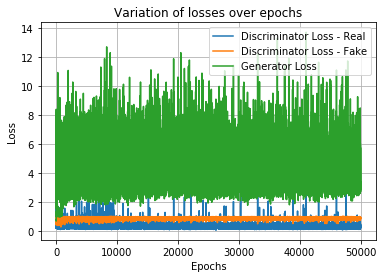

In [105]:
img_generated=train_gan(epochs=100, batch_size=10000, save_interval=10)

### Generate test set using GAN model

In [107]:
#Rescale -1 to 1
img_test_gan = (img_test.astype(np.float32) - 127.5) / 127.5

In [108]:
def save_imgs(epoch):
    r, c = 5, 5
    noise1 = np.random.normal(0, 1, (r * c, 100))
    gen_imgs1 = generator.predict(noise1)

    # Rescale images 0 - 1
    gen_imgs1 = (1/2.5) * gen_imgs1 + 0.5

    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i,j].imshow(gen_imgs1[cnt, :,:,:])
            axs[i,j].axis('off')
            cnt += 1
    fig.savefig("output/4/%d.png" % epoch)
    plt.close()

In [109]:
def get_test_gan(epochs, batch_size, save_interval):
    start_time = time.time()
    for epoch in range(epochs):

        # ---------------------
        #  Train Discriminator
        # ---------------------

        # Select a random half batch of images
        idx = np.random.randint(0, img_test_gan.shape[0], 2000)
        imgs = img_test_gan[idx]

        noise = np.random.normal(0, 1, (2000, 100))

        # Generate a half batch of new images
        gen_imgs = generator.predict(noise)
        return_value=gen_imgs

        # Train the discriminator
        d_loss_real = discriminator.train_on_batch(imgs, np.ones((2000, 1)))
        d_loss_fake = discriminator.train_on_batch(gen_imgs, np.zeros((2000, 1)))
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)


        # ---------------------
        #  Train Generator
        # ---------------------

        noise = np.random.normal(0, 1, (2000, 100))

        # The generator wants the discriminator to label the generated samples
        # as valid (ones)
        valid_y = np.array([1] * 2000)
    
        # Train the generator
        g_loss = combined.train_on_batch(noise, valid_y)

        # Plot the progress
        if epoch % 10 == 0:
            print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

        # If at save interval => save generated image samples
        if epoch % save_interval == 0:
            save_imgs(epoch)
    end_time = time.time()



    time_dif = end_time - start_time
    print("Time usage: " + str(timedelta(seconds=int(round(time_dif)))))
    return return_value

In [115]:
epochs=50
batch_size=2000
save_interval=10

In [116]:
test_gan=get_test_gan(epochs=50, batch_size=2000, save_interval=10)

/anaconda3/lib/python3.6/site-packages/keras/engine/training.py:973: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [D loss: 8.070362, acc.: 49.83%] [G loss: 6.990942]
10 [D loss: 8.070463, acc.: 49.78%] [G loss: 6.909694]
20 [D loss: 8.068580, acc.: 49.80%] [G loss: 6.947198]
30 [D loss: 8.066846, acc.: 49.80%] [G loss: 7.005332]
40 [D loss: 8.072788, acc.: 49.63%] [G loss: 6.893285]
Time usage: 0:02:49


## Part 4 Use SRGAN pre-processed dataset to train the CNN model

### 1. Re-label and convert image format
As loaded image files are not ordered in acending, we have to change the order of the labels to make sure the images has the right labels.

get label set with only cat and dog

In [117]:
cat = label1['label'] == "cat"
dog = label1['label'] == "dog"
df_labels=label1[cat | dog]

get image file directorys

In [118]:
list_new_label=glob(os.path.join(data_dir, '*.png'))

get file names without extention

In [119]:
files_no_ext = [".".join(f.split(".")[:-1]) for f in list_new_label if os.path.isfile(f)]

store the file names in label_new

In [120]:
list_order=[]
for file in files_no_ext:    
    list_order.append(int(file.split('/')[-1]))
label_new=[]

creat new label set with the order of the image order

In [121]:
for i in list_order:
    label_new.append(df_labels['label'][i-1])
for i in range(len(label_new)):
    if label_new[i]=='cat':
        label_new[i]=3
    else:
        label_new[i]=5

transfer label to the format to fit for training

In [122]:
labels_train_gan=one_hot_encoded(class_numbers=label_new, num_classes=num_classes)

In [123]:
img_generated.shape

(10000, 32, 32, 3)

### Create a new CNN model and train with pre-processed dataset
The following part is the same as above 

In [124]:
path_board='/Users/lisha/Desktop/tensor_board/'

In [125]:
train_batch_size = 64
num_iterations=10000

In [126]:
tf.reset_default_graph()

In [127]:
x = tf.placeholder(tf.float32, shape=[None, img_size, img_size, num_channels], name='x')
y_true = tf.placeholder(tf.float32, shape=[None, num_classes], name='y_true')
y_true_cls = tf.argmax(y_true, dimension=1)

Instructions for updating:
Use the `axis` argument instead


In [128]:
global_step = tf.Variable(initial_value=0, name='global_step')
_, loss = create_network(training=True)
with tf.name_scope('train'):
    optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(loss, global_step=global_step)
y_pred, _ = create_network(training=False)
y_pred_cls = tf.argmax(y_pred, dimension=1)
with tf.name_scope('accuracy'):
    correct_prediction = tf.equal(y_pred_cls, y_true_cls)
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
session = tf.Session()

Instructions for updating:
Use the retry module or similar alternatives.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.



In [129]:
w = tf.Variable(tf.truncated_normal([5,5,3,64], stddev=0.1),name="w")
b = tf.Variable(tf.constant(0.1,shape=[64]), name="b")

In [130]:
init_op = tf.global_variables_initializer()
session.run(init_op)

In [131]:
summary = tf.summary.merge_all()
summary_writer = tf.summary.FileWriter(path_board+'after_gan1')
summary_writer.add_graph(session.graph)

In [132]:
l_acc_gan, l_step_gan, t_diff_gan, l_time_gan=get_acc(train_batch_size=train_batch_size, images_train=img_generated, labels_train=labels_train_gan)

Global Step:    100, Training Batch Accuracy:  56.2%
Global Step:    200, Training Batch Accuracy:  54.7%
Global Step:    300, Training Batch Accuracy:  60.9%
Global Step:    400, Training Batch Accuracy:  51.6%
Global Step:    500, Training Batch Accuracy:  56.2%
Global Step:    600, Training Batch Accuracy:  51.6%
Global Step:    700, Training Batch Accuracy:  59.4%
Global Step:    800, Training Batch Accuracy:  71.9%
Global Step:    900, Training Batch Accuracy:  59.4%
Global Step:   1000, Training Batch Accuracy:  60.9%
Global Step:   1100, Training Batch Accuracy:  54.7%
Global Step:   1200, Training Batch Accuracy:  46.9%
Global Step:   1300, Training Batch Accuracy:  59.4%
Global Step:   1400, Training Batch Accuracy:  59.4%
Global Step:   1500, Training Batch Accuracy:  50.0%
Global Step:   1600, Training Batch Accuracy:  51.6%
Global Step:   1700, Training Batch Accuracy:  56.2%
Global Step:   1800, Training Batch Accuracy:  65.6%
Global Step:   1900, Training Batch Accuracy: 

### Training result
After 10k steps and 2.5 hours training. The training accuracy reached similar as the original model. Then I tested the model with pre-processed testing dataset. The accuracy dropped to 51.2% as shown in image above.

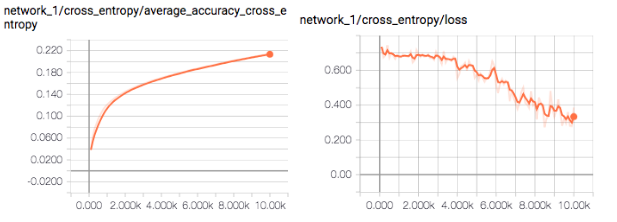

In [24]:
Image("img_src/tensorBoard2.png")

### Monitor the training process with tensorboard. 
The average accuracy cross entropy is approaching 0.22.<br>
The loss is approaching 0.3.

In [134]:
batch_size = 256 
t_gan=get_test_acc(batch_size=batch_size, images_test=test_gan)

Accuracy on Test-Set: 51.2% (1025 / 2000)


## Conclusion and Disscussion

In this research so far, I got the image classification testing accuracy of 54%. It took 4 hours and 10k steps to train the model. The accuracy of  SRGAN model is 90%. It took around 1 hour and 10k steps to train it. I tried to explore the way to improve accuracy and efficiency by changing activation functions, model architectures, training epochs, loss function and so on. They are not g helping very much with the improvement. But I got a better configuration. Using relu as activation function and initialise  the model with bias and weights of below values.
w = tf.Variable(tf.truncated_normal([5,5,3,64], stddev=0.1),name="w")
b = tf.Variable(tf.constant(0.1,shape=[64]), name="b")
And set the batch size to 64. 

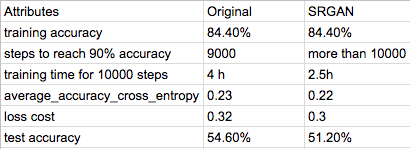

In [21]:
Image("img_src/compare.png")

The experiment results are shown in image above. There is a 37.5% improvement of training efficiency. And the test accuracy dropped from 54.6% to 51.2%. There are not very big difference for the other attributes. However it took a long time to train the SRGAN model. If you want to get better photo quality you will need to train more. And this will take longer. If I take the training of SRGAN model into consideration, the training efficiency of orginal CNN model is  better. 

There is still room to make improvement. Unfortunately, I didn’t run the training on the cloud. It took me lots of time to train my model. It’s not easy to monitor and compare the result if I want to make any change to the model. The original model still needs more improvement. There are some ways to improve the accuracy. Such as training the CNN models more. And also we can improve the quality of dataset by training SRGAN model more. There are lots of SRGAN models. I can try other models. I can also change the activation function,  architecture, loss function or initialization of the model. Till now, the CNN model based on SRGAN has little improvement from original CNN. There is still long way to go.


## References
* [1] Learning Multiple Layers of Features from Tiny Images, Alex Krizhevsky, 2009.
* [2] Photo-Realistic Single Image Super-Resolution Using a Generative Adversarial Network, Christian Ledig, Lucas Theis, Ferenc Huszar, Jose Caballero, Andrew Cunningham, ´ Alejandro Acosta, Andrew Aitken, Alykhan Tejani, Johannes Totz, Zehan Wang, Wenzhe Shi Twitter, 2016
* [3] Beyond a Gaussian Denoiser: Residual Learning of Deep CNN for Image Denoising, Kai Zhang, Wangmeng Zuo, Yunjin Chen, Deyu Meng, and Lei Zhang, 2017
* [4] Real-Time Single Image and Video Super-Resolution Using an Efficient Sub-Pixel Convolutional Neural Network, Wenzhe Shi, Jose Caballero, Ferenc Huszar´ , Johannes Totz, Andrew P. Aitken, Rob Bishop1 , Daniel Rueckert, Zehan Wang, 2016
* [5] A. Krizhevsky, I. Sutskever, and G. Hinton. Imagenet classification with deep convolutional neural networks. In NIPS, pages 1106–1114, 2012
* [6] Learning Fine-grained Image Similarity with Deep Ranking by Jiang Wang, Yang Song, Thomas Leung, Chuck Rosenberg, Jingbin Wang, James Philbin, Bo Chen, Ying Wu1
* [7] Accelerating the Super-Resolution Convolutional Neural Network, Chao Dong, Chen Change Loy, and Xiaoou Tang, 2016
* [8] Is the deconvolution layer the same as a convolutional layer? Wenzhe Shi, Jose Caballero, Lucas Theis, Ferenc Huszar, Andrew Aitken, Christian Ledig, Zehan Wang,2016
